# Post impression regression

## Notebooks set-up

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

## 1. Data loading

In [2]:
# Load the post dataset
data_df = pd.read_csv('../data/posts.csv')

# Inspect
data_df.head()

,post_url,post_publish_date,impressions,post_text,word_count,n_tags,external_link,media,post_day
0,https://www.linkedin.com/feed/update/urn:li:ac...,2025-06-03,5582,Heres the plan for the Hugging Face Gradio Age...,68,0,False,True,Tuesday
1,https://www.linkedin.com/feed/update/urn:li:ac...,2025-06-13,4894,Congrats to everyone who finished the Gradio A...,113,1,True,True,Friday
2,https://www.linkedin.com/feed/update/urn:li:ac...,2025-08-21,1721,Has anyone tried marimo yet? Sounds great Pyth...,77,2,True,True,Thursday
3,https://www.linkedin.com/feed/update/urn:li:ac...,2025-07-15,1226,Do LLMs really utilize those impressively long...,55,4,True,True,Tuesday
4,https://www.linkedin.com/feed/update/urn:li:ac...,2025-06-06,620,For folks new to MCP like me and building clie...,40,0,True,True,Friday


In [3]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   post_url           50 non-null     object
 1   post_publish_date  50 non-null     object
 2   impressions        50 non-null     int64 
 3   post_text          50 non-null     object
 4   word_count         50 non-null     int64 
 5   n_tags             50 non-null     int64 
 6   external_link      50 non-null     bool  
 7   media              50 non-null     bool  
 8   post_day           50 non-null     object
dtypes: bool(2), int64(3), object(4)
memory usage: 3.0+ KB


## 2. EDA
### 2.1. Feature distributions
#### 2.1.1. Categorical features

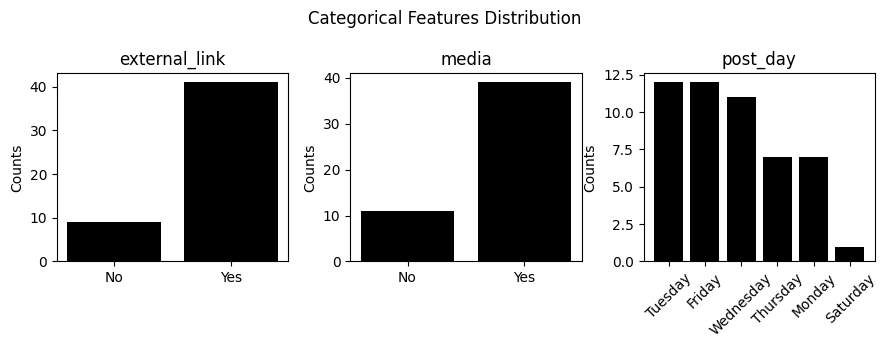

In [4]:
categorical_features = ['external_link', 'media', 'post_day']

fig, axs = plt.subplots(1, 3, figsize=(9, 3.5))

fig.suptitle('Categorical Features Distribution')

for i, categorical_feature in enumerate(categorical_features):

    axs[i].bar(
        data_df[categorical_feature].value_counts().index,
        data_df[categorical_feature].value_counts().values,
        color='black'
    )

    if categorical_feature != 'post_day':
        axs[i].set_xticks([0, 1])
        axs[i].set_xticklabels(['No', 'Yes'])

    if categorical_feature == 'post_day':
        axs[i].set_xticks(range(len(data_df[categorical_feature].value_counts())))
        axs[i].set_xticklabels(data_df[categorical_feature].value_counts().index, rotation=45)

    axs[i].set_title(categorical_feature)
    axs[i].set_ylabel('Counts')

fig.tight_layout()
fig.show()

#### 2.1.2. Numerical features

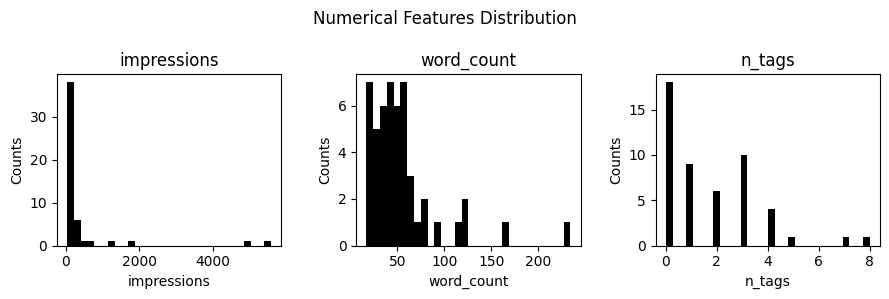

In [5]:
numerical_features = ['impressions', 'word_count', 'n_tags']

fig, axs = plt.subplots(1, 3, figsize=(9, 3))

fig.suptitle('Numerical Features Distribution')

for i, numerical_feature in enumerate(numerical_features):
    axs[i].hist(data_df[numerical_feature], bins=30, color='black')
    axs[i].set_title(numerical_feature)
    axs[i].set_xlabel(numerical_feature)
    axs[i].set_ylabel('Counts')

fig.tight_layout()
fig.show()

### 2.2. Feature interactions

#### 2.2.1. Categorical-categorical

In [6]:
categorical_feature_pairs = [
    ['external_link', 'media'],
    ['external_link', 'post_day'],
    ['media', 'post_day']
]

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

fig.suptitle('Categorical feature contingency tables')

for i, feature_pair in enumerate(categorical_feature_pairs):

    contingency_table = pd.crosstab(data_df[feature_pair[0]], data_df[feature_pair[1]])

    if feature_pair[1] == 'post_day':
        contingency_table = contingency_table[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']]

    chisquared_result = stats.chi2_contingency(contingency_table)

    axs[i].set_title(f'{feature_pair[0]} x {feature_pair[1]}\n$Chi^2$ p={chisquared_result[1]:.4f}')
    sns.heatmap(contingency_table, annot=True, fmt='d', cmap='Blues', ax=axs[i])

    if feature_pair[1] == 'post_day':
        axs[i].tick_params(axis='x', labelrotation=45)

fig.tight_layout()
fig.show()

#### 2.2.2. Numerical-categorical

In [7]:
fig, axs = plt.subplots(3, 3, figsize=(9, 8))

for i, categorical_feature in enumerate(categorical_features):

    fig.suptitle(f'Numerical-categorical feature interactions')

    for j, numerical_feature in enumerate(numerical_features):

        groups = [list(x) for _, x in data_df.dropna().groupby(data_df[categorical_feature])[numerical_feature]]

        if categorical_feature == 'post_day':
            result = stats.kruskal(*groups)
            axs[i,j].set_title(f'{categorical_feature} x {numerical_feature}\nH-test p={result.pvalue:.4f}')

        if categorical_feature != 'post_day':
            result = stats.mannwhitneyu(*groups)
            axs[i,j].set_title(f'{numerical_feature} x {categorical_feature}\nU-test p={result.pvalue:.4f}')

        sns.boxplot(data=data_df, x=categorical_feature, y=numerical_feature, ax=axs[i,j])

        if categorical_feature == 'post_day':
            axs[i,j].tick_params(axis='x', labelrotation=45)

    fig.tight_layout()
    fig.show()

#### 2.2.3. Numerical-numerical

In [8]:
numerical_feature_pairs = [['word_count', 'impressions'], ['n_tags', 'impressions'], ['word_count', 'n_tags']]

fig, axs = plt.subplots(1, 3, figsize=(9, 3.5))

fig.suptitle('Numerical feature interactions')

for i, feature_pair in enumerate(numerical_feature_pairs):

    result = stats.kendalltau(data_df[feature_pair[0]], data_df[feature_pair[1]])
    axs[i].set_title(f'{feature_pair[0]} x {feature_pair[1]}\nτ={result.correlation:.4f}, p={result.pvalue:.4f}')

    axs[i].scatter(data_df[feature_pair[0]], data_df[feature_pair[1]], color='black')
    axs[i].set_xlabel(feature_pair[0])
    axs[i].set_ylabel(feature_pair[1])

fig.tight_layout()
fig.show()

## 3. Data preparation

### 3.1. Feature selection

In [9]:
data_df = data_df[numerical_features + categorical_features]

### 3.2. Feature encoding

In [10]:
encoder = OrdinalEncoder()
data_df[categorical_features] = encoder.fit_transform(data_df[categorical_features])

### 3.3. Feature scaling

In [11]:
scaler = StandardScaler()
#data_df[numerical_features + categorical_features] = scaler.fit_transform(data_df[numerical_features + categorical_features])

## 3. Linear regression

### 3.1. Model training

In [ ]:
linear_model = LinearRegression()
result = linear_model.fit(data_df.drop('impressions', axis=1), data_df['impressions'])
rsq = linear_model.score(data_df.drop('impressions', axis=1), data_df['impressions'])
rmse = mean_squared_error(data_df['impressions'], linear_model.predict(data_df.drop('impressions', axis=1)), squared=False)
print(f'R\u00b2 = {rsq:.3f}')
print(f'RMSE = {rmse:.3f}')

In [13]:
import statsmodels.api as sm

features = data_df.drop('impressions', axis=1)
labels = data_df['impressions']

features = sm.add_constant(features, prepend=False)

# Fit and summarize OLS model
mod = sm.OLS(labels, features)
res = mod.fit()
print(res.summary())